#1. Import modules

In [1]:
from torchvision import transforms
from torchvision import datasets
import numpy as np
import PIL
import torch
import torch.nn as nn
import torchvision.datasets as dset

import torch.utils.data
import torchvision


#2. Set main parameters 

In [2]:
import custom_models

n_classes = 5
batch_size = 64
frame_size = (224, 224)
dataset_dir = 'oai224/test'

# choose torch device
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'


#3. Prepare dataset

In [3]:
from torch.utils.data.sampler import SequentialSampler

transforms_to_test = transforms.Compose([
              transforms.Resize(frame_size), 
              transforms.ToTensor(),
              transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ])

test_dataset = datasets.ImageFolder(dataset_dir, transform=transforms_to_test)
test_idx = list(range(len(test_dataset.imgs)))
test_sampler = SequentialSampler(test_idx)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler=test_sampler)


In [5]:
# cnn_model = densenet121_model(n_classes)
# cnn_model = densenet161_model(n_classes)
cnn1 = custom_models.AntonyCnn(n_classes)
model_ckpt_file1 = 'models/antony_21.ckpt'

cnn2 = custom_models.AntonyCnn(n_classes)
model_ckpt_file2= 'models/antony_42.ckpt'

cnn3 = custom_models.AntonyCnn(n_classes)
model_ckpt_file3 = 'models/antony_84.ckpt'


#4. Prepare ensemble object

In [11]:
class Ensemble(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super(Ensemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
      
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        
        # sum
        xx = x1.add(x2).add(x3)
    
        return nn.functional.softmax(xx, 1)

cnn1.load_state_dict(torch.load(model_ckpt_file1, map_location=torch.device(device)))
cnn2.load_state_dict(torch.load(model_ckpt_file2, map_location=torch.device(device)))  
cnn3.load_state_dict(torch.load(model_ckpt_file3, map_location=torch.device(device)))  

cnn_model = Ensemble(cnn1, cnn2, cnn3)
cnn_model.type(torch.FloatTensor)


Ensemble(
  (modelA): AntonyCnn(
    (features): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(11, 11), stride=(2, 2), padding=(5, 5), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (6): BasicConv

#5. Check accuracy

In [7]:
import utils

total_params = sum(p.numel() for p in cnn_model.parameters())
total_trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print("parameters number: ", total_params)
print("trainable parameters number: ", total_trainable_params)

predictions = []
raw_predictions = []
ground_truth = []

with torch.no_grad():
  print("compute accuracy...")
  test_accuracy, predictions, ground_truth, raw_predictions = utils.compute_accuracy(cnn_model, test_loader)
  print("test accuracy:", test_accuracy)


parameters number:  19974063
trainable parameters number:  19974063
compute accuracy...
test accuracy: 0.6068840579710145


#6. Calculate metrics

In [8]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='weighted')
    recall = metrics.recall_score(true,pred,average='weighted') # average='weighted'
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='weighted')
    print('Mean \n  precision: {} \n  recall: {}, \n  accuracy: {}, \n  f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

performance_matrix(ground_truth, predictions)

# 
from tabulate import tabulate
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(ground_truth, predictions)

print('\n')
print('rows is precision, recall, fscore and support:')
print(tabulate([precision, recall, fscore, support], headers=['0' , '1' , '2' , '3', '4'], tablefmt='orgtbl'))

print('\n')
print('per-class accuracy:')
cm = confusion_matrix(ground_truth, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(tabulate([cm.diagonal()], headers=['0' , '1' , '2' , '3', '4'], tablefmt='orgtbl'))


Mean 
  precision: 54.9374696691502 
  recall: 60.68840579710145, 
  accuracy: 60.68840579710145, 
  f1_score: 54.30462656182392


rows is precision, recall, fscore and support:
|          0 |           1 |          2 |          3 |         4 |
|------------+-------------+------------+------------+-----------|
|   0.581854 |   0.2       |   0.621693 |   0.714912 |  0.8125   |
|   0.923318 |   0.0135135 |   0.525727 |   0.730942 |  0.254902 |
|   0.713854 |   0.0253165 |   0.569697 |   0.722838 |  0.38806  |
| 639        | 296         | 447        | 223        | 51        |


per-class accuracy:
|        0 |         1 |        2 |        3 |        4 |
|----------+-----------+----------+----------+----------|
| 0.923318 | 0.0135135 | 0.525727 | 0.730942 | 0.254902 |


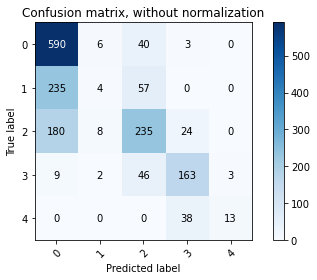

In [9]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


plot_confusion_matrix(ground_truth, predictions, classes=["0", "1", "2", "3", "4"],title='Confusion matrix, without normalization')


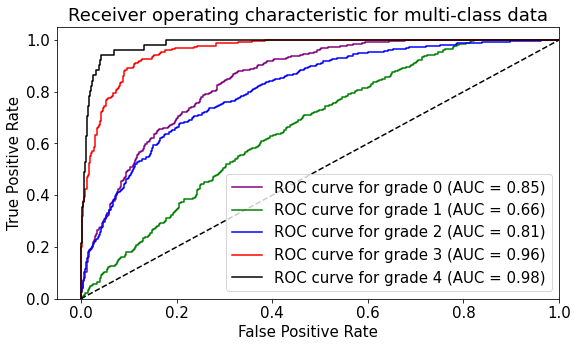

In [10]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

y_score = np.array(raw_predictions)
y_test = ground_truth

# Binarize the output
if n_classes == 2:
    _classes= [0, 1]
    colors =  ['blue', 'red']
    y_test = label_binarize(y_test, range(n_classes+1))[:,:-1]
else:
    _classes= [0, 1, 2, 3, 4]
    colors = ['purple', 'green', 'blue', 'red', 'black']
    y_test = label_binarize(y_test, classes=_classes,neg_label=0, pos_label=1, sparse_output=False)

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams.update({'font.size': 15})

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve for grade {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")

plt.show()
